#***Project: Liver Cancer Image Segregation Model***

Install &  Import Required Libraries

In [37]:
import os
import zipfile
import numpy as np
import pydicom
import torch
from tcia_utils import nbia
import matplotlib.pyplot as plt
from monai.bundle.config_parser import ConfigParser
from monai.bundle.scripts import download
from monai.transforms.io.array import LoadImage
from monai.transforms.io.dictionary import LoadImaged
from monai.transforms.spatial.array import Orientation
from monai.transforms.utility.array import EnsureChannelFirst
from monai.transforms.utility.dictionary import EnsureChannelFirstd
from monai.transforms.compose import Compose
from monai.transforms.spatial.dictionary import Orientationd
from rt_utils import RTStructBuilder
import json
import glob
import random
import nibabel

#***Open CT Image***

First we'll download CT data obtained from https://nbia.cancerimagingarchive.net/

In [38]:
cart_name='nbia-52471717085431134'
cart_data=nbia.getSharedCart(cart_name)
df=nbia.downloadSeries(cart_data,format="df",path='dataset')

2024-05-31 00:29:21,773:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-52471717085431134'}
2024-05-31 00:29:23,305:INFO:Downloading 1 Series Instance UIDs (scans).
2024-05-31 00:29:24,482:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.1706.8374.281650679207816520863173918688 already downloaded.
2024-05-31 00:29:24,482:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.


In [39]:

CT_folder=os.path.join(data_dir,'1.3.6.1.4.1.14519.5.2.1.1706.8374.281650679207816520863173918688')

#***Using Pydicom To Read Images***

In [40]:
read_img=pydicom.read_file(os.path.join(CT_folder,'1-095.dcm'))

Obtain pixel data by accessing the pixel_array attribute

In [41]:
image=read_img.pixel_array
image.shape
image=read_img.RescaleSlope*image+read_img.RescaleIntercept

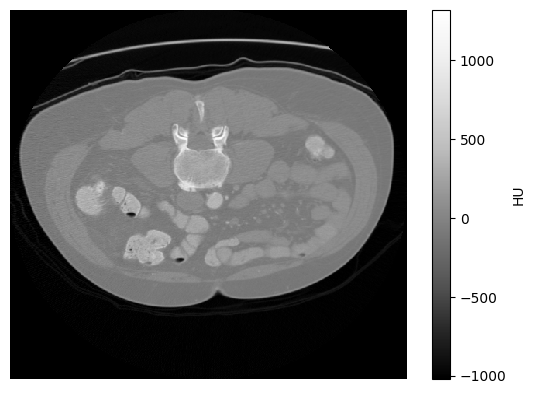

In [42]:
plt.pcolormesh(image,cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

#***Using MONAI For Medical Data Opening***

**MONAI** (Medical Natural Language Artificial Intelligence) is a cutting-edge AI platform designed to unlock
the potential of medical data.
With MONAI you can:
1. **Annotate medical images**: MONAI's AI-powered annotation tools enable you to label
medical images quickly and accurately,reducing the time and cost associated with manual annotation.
2. **Extract insights from medical text**: MONAI's natural language processing (NLP) capabilities
allow you to extract relevant information from unstructured medical text, such as clinical notes and
research articles.
3. **Integrate medical data**: MONAI's data integration tools enable you to combine data from
different sources, including electronic health records (EHRs), medical imaging, and genomics data
, creating a unified view of patient data.
4. **Develop predictive models**: MONAI's machine learning algorithms enable you to build
predictive models that can identify patterns and trends in medical data, helping you to make
more informed decisions.
5. **Collaborate with others**: MONAI's cloud-based platform enables secure collaboration and
data sharing among researchers, clinicians, and other stakeholders, facilitating the development
of new medical insights and treatments.

In [43]:
image_loader=LoadImage(image_only=True)
CT=image_loader(CT_folder)

c:\Users\Administrator\.vscode\.conda\lib\site-packages\monai\transforms\io\array.py:255: UserWarning: Failed to read dataset\1.3.6.1.4.1.14519.5.2.1.1706.8374.281650679207816520863173918688\LICENSE with exception: 
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..
  img = reader.read(filename)


CT contains both pixel and image metadata

In [44]:
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-201.5, -180.0, -45.0]},
 '00280030': {'vr': 'DS', 'Value': [0.703125, 0.703125, 3.7301587301587302]},
 'spacing': array([0.703125  , 0.703125  , 1.24338624]),
 'lastImagePositionPatient': array([-201.5, -180. , -280. ]),
 spatial_shape: (512, 512, 190),
 space: RAS,
 original_affine: array([[ -0.703125  ,   0.        ,   0.        , 201.5       ],
        [  0.        ,  -0.703125  ,   0.        , 180.        ],
        [  0.        ,   0.        ,  -1.24338624, -45.        ],
        [  0.        ,   0.        ,   0.        ,   1.        ]]),
 affine: tensor([[ -0.7031,   0.0000,   0.0000, 201.5000],
         [  0.0000,  -0.7031,   0.0000, 180.0000],
         [  0.0000,   0.0000,  -1.2434, -45.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64),
 original_channel_dim: nan,
 'filename_or_obj': 'dataset\\1.3.6.1.4.1.14519.5.2.1.1706.8374.281650679207816520

In [45]:
CT_coronal_slice=CT[:,256].cpu().numpy()

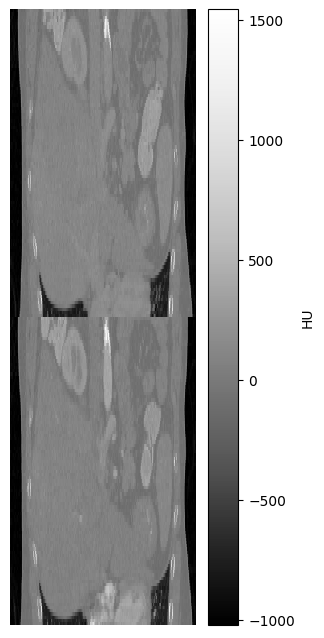

In [46]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T,cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [47]:
channel_transform=EnsureChannelFirst()
CT=channel_transform(CT)
CT.shape

torch.Size([1, 512, 512, 190])

Now reorient the CT Image

In [48]:
orientation_transform=Orientation(axcodes=('LPS'))
CT=orientation_transform(CT)

OptionalImportError: import nibabel (No module named 'nibabel').

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies